In [1]:
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import plotly.express as px

# Import the Data

In [2]:
Booking = pd.read_csv("../input/hotel-data/bookings.csv",delimiter="|")

In [3]:
Booking.head(2)

,id,room,start date,end date,request id
0,1,L0,2016-02-07,2016-02-10,1
1,2,L0,2016-03-13,2016-03-21,2


In [4]:
Booking.shape

(10346, 5)

In [5]:
Food_orders = pd.read_csv("../input/hotel-data/food-orders.csv",delimiter="|")

In [6]:
Food_orders.head(2)

,dest room,bill room,date,time,#orders,menu id
0,L0,L0,2016-02-09,10:15:00,3,6
1,restaurant,L0,2016-02-07,11:35:00,5,8


In [7]:
Food_orders.shape

(2965, 6)

In [8]:
Menu = pd.read_csv("../input/hotel-data/menu.csv",delimiter="|")

In [9]:
Menu.columns = ['menu id','name','price','category']
Menu.head(2)

,menu id,name,price,category
0,0,water,2.5,drink
1,1,soft-drink,3.0,drink


In [10]:
Menu.shape

(16, 4)

In [11]:
Request = pd.read_csv("../input/hotel-data/requests.csv",delimiter="|")

In [12]:
Request.head(2)

,request id,client name,room type,request type,start date,end date,#adults,#children
0,1,Dr. Iza Gerhold,conference_room_large,conference,2016-02-07,2016-02-10,27,0
1,2,Ila Sawayn,conference_room_large,conference,2016-03-13,2016-03-21,22,0


In [13]:
FirstName = Request["client name"].str.split("[,.]")
# now strip the white spaces from the Salutation
Title = np.array([str.strip(name[0]) for name in FirstName.values])

In [14]:
#DR
#Request['DR_Title'] = np.where(Title=='Dr','Doctor','Not Known')

In [15]:
#Male
Request['Male'] = np.where(Title=='Mr',1,0)

In [16]:
#Female
miss_title = np.array([x[0:4] for x in Title])
Request['Female'] = np.where((Title=='Mrs') | (Title=='Ms') | (miss_title=='Miss'),2,0)

In [17]:
#Combining Male, Female and Not Known

Request['Sex'] = Request['Male'] + Request['Female'] # it will either be male or female so it cant be 1+2, and Not known will be 3
sex = np.array(Request['Sex'])

In [18]:
Request['Sex'] = np.where(sex==1,"Male",np.where(sex==2,'Female','Not Known'))
Request = Request.drop(['Male','Female'],axis=1)

In [19]:
# Professionals : 'DVM','PHD','DDS','MD'
prof = np.array(Request['client name'])
Prof_Title = np.array([x[-3:] for x in prof])

In [20]:
Request['Profession'] = np.where((Prof_Title=='DVM') | (Prof_Title=='PhD') | (Prof_Title=='DDS') | (Prof_Title=='DVM'),'Professional',np.where(Title=='Dr','Doctor','Not Known'))

In [21]:
# There are entries with Double Room and double room. this created missing values while joining the tables
Request['room type'] = Request['room type'].replace(['Double_room'],'double_room')

In [22]:
Request.head(2)

,request id,client name,room type,request type,start date,end date,#adults,#children,Sex,Profession
0,1,Dr. Iza Gerhold,conference_room_large,conference,2016-02-07,2016-02-10,27,0,Not Known,Doctor
1,2,Ila Sawayn,conference_room_large,conference,2016-03-13,2016-03-21,22,0,Not Known,Not Known


In [23]:
Request.shape

(5000, 10)

In [24]:
Rooms = pd.read_csv("../input/hotel-data/rooms.csv",delimiter="|")

In [25]:
Rooms.columns = ['id','price/day','capacity','room type','prefix']
Rooms.head(5)

,id,price/day,capacity,room type,prefix
0,1,150,3,deluxe_room,X
1,2,100,3,double_room,D
2,3,80,15,conference_room_small,S
3,4,80,1,normal_room,N
4,5,150,50,conference_room_large,L


In [26]:
Rooms.shape

(5, 5)

# Explore the Data

#### Split the Date to DD, MM, and YY For Booking Data and Request Data

In [27]:
Booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10346 entries, 0 to 10345
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          10346 non-null  int64 
 1   room        10346 non-null  object
 2   start date  10346 non-null  object
 3   end date    10346 non-null  object
 4   request id  10346 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 404.3+ KB


In [28]:
Booking_ac = np.vstack(Booking['start date'].astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
Booking['Booking_ST_Year'] = Booking_ac[:,0]
Booking['Booking_ST_Month']= Booking_ac[:,1]
Booking['Booking_ST_Day'] = Booking_ac[:,2]

In [29]:
Booking_ac = np.vstack(Booking['end date'].astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
Booking['Booking_ET_Year'] = Booking_ac[:,0]
Booking['Booking_ET_Month']= Booking_ac[:,1]
Booking['Booking_ET_Day'] = Booking_ac[:,2]

In [30]:
Booking['start date'] = pd.to_datetime(Booking['start date'])
Booking['end date'] = pd.to_datetime(Booking['end date'])
Booking['Reservation_Booking'] = (Booking['end date'] - Booking['start date']).dt.days

In [31]:
Booking = Booking.drop(['start date', 'end date'], axis=1)
Booking.head(2)

,id,room,request id,Booking_ST_Year,Booking_ST_Month,Booking_ST_Day,Booking_ET_Year,Booking_ET_Month,Booking_ET_Day,Reservation_Booking
0,1,L0,1,2016,2,7,2016,2,10,3
1,2,L0,2,2016,3,13,2016,3,21,8


In [32]:
Request_ac = np.vstack(Request['start date'].astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
Request['Request_ST_Year'] = Request_ac[:,0]
Request['Request_ST_Month']= Request_ac[:,1]
Request['Request_ST_Day'] = Request_ac[:,2]

In [33]:
Request_ac = np.vstack(Request['end date'].astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
Request['Request_ET_Year'] = Request_ac[:,0]
Request['Request_ET_Month']= Request_ac[:,1]
Request['Request_ET_Day'] = Request_ac[:,2]

In [34]:
Request['start date'] = pd.to_datetime(Request['start date'])
Request['end date'] = pd.to_datetime(Request['end date'])
Request['Reservation_Request'] = (Request['end date'] - Request['start date']).dt.days

In [35]:
Request = Request.drop(['start date', 'end date'], axis=1)
Request.head(4)

,request id,client name,room type,request type,#adults,#children,Sex,Profession,Request_ST_Year,Request_ST_Month,Request_ST_Day,Request_ET_Year,Request_ET_Month,Request_ET_Day,Reservation_Request
0,1,Dr. Iza Gerhold,conference_room_large,conference,27,0,Not Known,Doctor,2016,2,7,2016,2,10,3
1,2,Ila Sawayn,conference_room_large,conference,22,0,Not Known,Not Known,2016,3,13,2016,3,21,8
2,3,Iverson McCullough,double_room,business,2,1,Not Known,Not Known,2016,2,19,2016,2,20,1
3,4,Katharyn Goyette DVM,deluxe_room,business,1,0,Not Known,Professional,2016,1,22,2016,1,26,4


 1. Merge Booking Table with Request!

In [36]:
Booking_Request = Booking.merge(Request, on='request id', how='left')

In [37]:
Booking_Request = Booking_Request.drop(['client name','Request_ST_Year','Request_ET_Year','Booking_ET_Year','Booking_ST_Year','request id'],axis=1)
Booking_Request.head(5)

,id,room,Booking_ST_Month,Booking_ST_Day,Booking_ET_Month,Booking_ET_Day,Reservation_Booking,room type,request type,#adults,#children,Sex,Profession,Request_ST_Month,Request_ST_Day,Request_ET_Month,Request_ET_Day,Reservation_Request
0,1,L0,2,7,2,10,3,conference_room_large,conference,27,0,Not Known,Doctor,2,7,2,10,3
1,2,L0,3,13,3,21,8,conference_room_large,conference,22,0,Not Known,Not Known,3,13,3,21,8
2,3,D2,2,19,2,20,1,double_room,business,2,1,Not Known,Not Known,2,19,2,20,1
3,4,X0,1,22,1,26,4,deluxe_room,business,1,0,Not Known,Professional,1,22,1,26,4
4,5,L0,2,22,2,26,4,conference_room_large,party,24,26,Not Known,Not Known,2,22,2,26,4


2. Merge Booking Request with Room

In [38]:
Booking_Request_R = Booking_Request.merge(Rooms, on='room type', how='left')

In [39]:
Booking_Request_R = Booking_Request_R.drop(['id_x','id_y','prefix'],axis=1)

Booking_Request_R.head(5)

,room,Booking_ST_Month,Booking_ST_Day,Booking_ET_Month,Booking_ET_Day,Reservation_Booking,room type,request type,#adults,#children,Sex,Profession,Request_ST_Month,Request_ST_Day,Request_ET_Month,Request_ET_Day,Reservation_Request,price/day,capacity
0,L0,2,7,2,10,3,conference_room_large,conference,27,0,Not Known,Doctor,2,7,2,10,3,150,50
1,L0,3,13,3,21,8,conference_room_large,conference,22,0,Not Known,Not Known,3,13,3,21,8,150,50
2,D2,2,19,2,20,1,double_room,business,2,1,Not Known,Not Known,2,19,2,20,1,100,3
3,X0,1,22,1,26,4,deluxe_room,business,1,0,Not Known,Professional,1,22,1,26,4,150,3
4,L0,2,22,2,26,4,conference_room_large,party,24,26,Not Known,Not Known,2,22,2,26,4,150,50


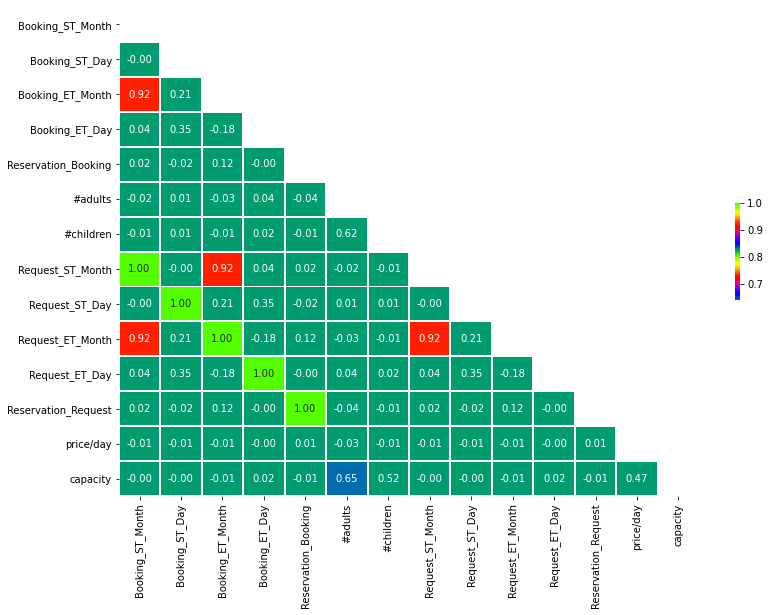

In [40]:
# Compute the correlation matrix
corr = Booking_Request_R.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13,9))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,vmin=0.64,
                annot=True,fmt='.2f', cbar_kws={"shrink":.2})

Once we see the corellation, We can remove the following variables:

Request_ST_Month, Request_ET_Month, Request_ST_Day, Request_ET_Day, and Reservation_Request.

In [41]:
Booking_Request_R = Booking_Request_R.drop(['Request_ST_Month','Request_ET_Month','Request_ST_Day','Request_ET_Day','Reservation_Request'],axis=1)

In [42]:
#Also remove Booking end day and booking end month, they wont be much relevant to the visualizations related to revenue.
Booking_Request_R = Booking_Request_R.drop(['Booking_ET_Month','Booking_ET_Day'],axis=1)

In [43]:
#Calculate the revenue from each booking
Booking_Request_R['Revenue'] = Booking_Request_R['Reservation_Booking'] * Booking_Request_R['price/day'] 
Booking_Request_R.head(2)

,room,Booking_ST_Month,Booking_ST_Day,Reservation_Booking,room type,request type,#adults,#children,Sex,Profession,price/day,capacity,Revenue
0,L0,2,7,3,conference_room_large,conference,27,0,Not Known,Doctor,150,50,450
1,L0,3,13,8,conference_room_large,conference,22,0,Not Known,Not Known,150,50,1200


#### Check for the Missing Values. As they may have some insights for Visualizations

In [44]:
obs = Booking_Request_R.isnull().sum().sort_values(ascending = False)
percent = round(Booking_Request_R.isnull().sum().sort_values(ascending = False)/len(Booking_Request_R)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
Revenue,0,0.0
capacity,0,0.0
price/day,0,0.0
Profession,0,0.0
Sex,0,0.0
#children,0,0.0
#adults,0,0.0
request type,0,0.0
room type,0,0.0
Reservation_Booking,0,0.0


### Visualize Revenue and Booking Orders generated over months and days

In [45]:
Booking_Request_R.head(2)

,room,Booking_ST_Month,Booking_ST_Day,Reservation_Booking,room type,request type,#adults,#children,Sex,Profession,price/day,capacity,Revenue
0,L0,2,7,3,conference_room_large,conference,27,0,Not Known,Doctor,150,50,450
1,L0,3,13,8,conference_room_large,conference,22,0,Not Known,Not Known,150,50,1200


In [46]:
Booking_Revenue_ByMonth = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Month"],sort=True)["Revenue"].sum()).reset_index()

In [47]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Indicator(
    value = Booking_Revenue_ByMonth["Revenue"][1],
    delta = {'reference': Booking_Revenue_ByMonth["Revenue"][0]},
    title = {'text': "Revenue ($) on Booking : Month 2"},
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))

fig.add_trace(go.Indicator(
    value = Booking_Revenue_ByMonth["Revenue"][2],
    delta = {'reference': Booking_Revenue_ByMonth["Revenue"][1]},
    title = {'text': "Revenue ($) on Booking : Month 3"},
    gauge = {
        'axis' : {'visible': False}},
    domain = {'row': 0, 'column': 1}))


fig.update_layout(
    width=900,
    height=300,
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'mode' : "number+delta+gauge",
        'delta' : {'reference': 50}}]
                         }})

#### Visualizing Reservations Booking and Revenue By Request Type

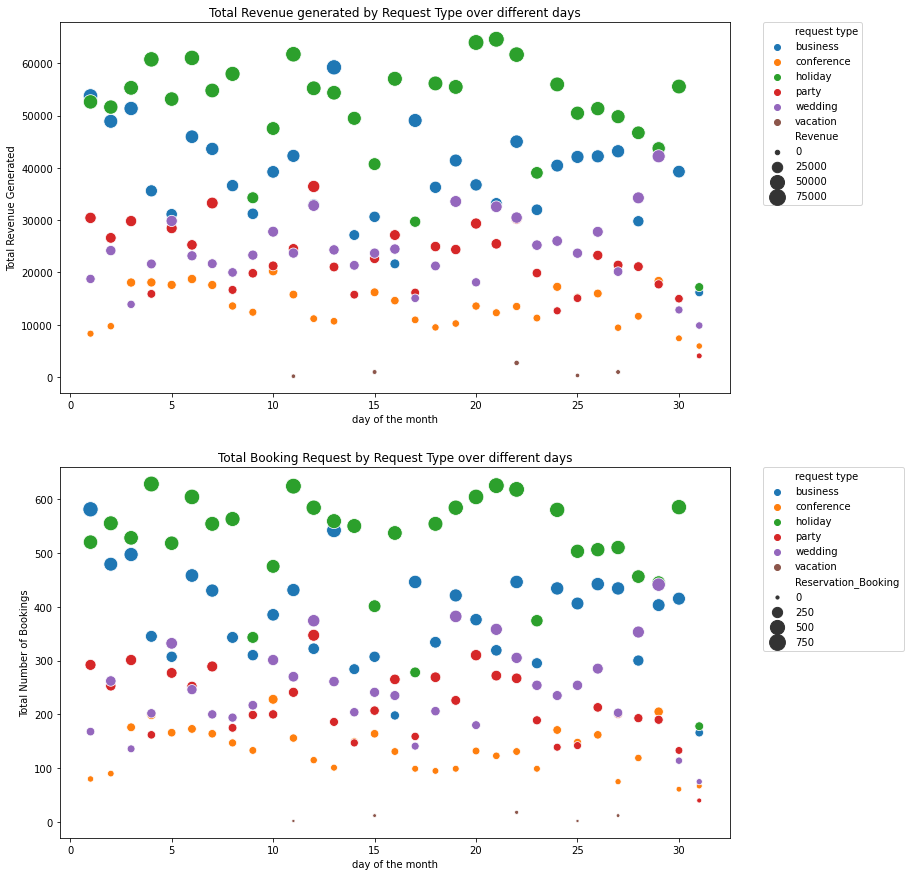

In [48]:
#Total Orders
Booking_Request_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","request type",],sort=True)["Reservation_Booking"].sum()).reset_index()
# Revenue
Booking_Revenue_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","request type",],sort=True)["Revenue"].sum()).reset_index()


fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.scatterplot(x= Booking_Request_ByDay["Booking_ST_Day"], y= Booking_Request_ByDay["Reservation_Booking"],hue=Booking_Request_ByDay["request type"],size=Booking_Request_ByDay["Reservation_Booking"],sizes=(10, 250), data=Booking_Request_ByDay,ax=ax2)
ax2.set(xlabel='day of the month', ylabel='Total Number of Bookings',title="Total Booking Request by Request Type over different days",label='big')

# Put the legend out of the figure
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.scatterplot(x= Booking_Revenue_ByDay["Booking_ST_Day"], y= Booking_Revenue_ByDay["Revenue"],hue=Booking_Revenue_ByDay["request type"], size=Booking_Revenue_ByDay["Revenue"],sizes=(20, 250), data=Booking_Revenue_ByDay,ax=ax1)
ax1.set(xlabel='day of the month', ylabel='Total Revenue Generated',title="Total Revenue generated by Request Type over different days",label='big')

# Put the legend out of the figure
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Visualizing Reservations Booking and Revenue By Room Type

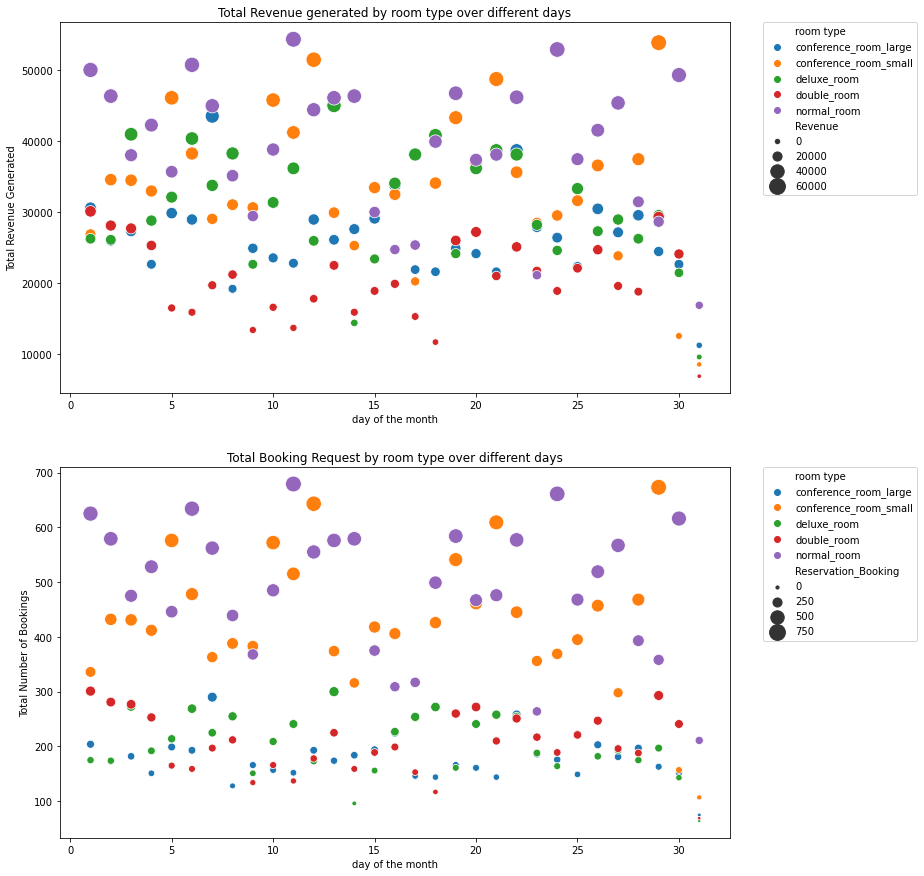

In [49]:
#Total Orders
Booking_Request_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","room type",],sort=True)["Reservation_Booking"].sum()).reset_index()
# Revenue
Booking_Revenue_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","room type",],sort=True)["Revenue"].sum()).reset_index()


fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.scatterplot(x= Booking_Request_ByDay["Booking_ST_Day"], y= Booking_Request_ByDay["Reservation_Booking"],hue=Booking_Request_ByDay["room type"],size=Booking_Request_ByDay["Reservation_Booking"],sizes=(10, 250), data=Booking_Request_ByDay,ax=ax2)
ax2.set(xlabel='day of the month', ylabel='Total Number of Bookings',title="Total Booking Request by room type over different days",label='big')

# Put the legend out of the figure
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.scatterplot(x= Booking_Revenue_ByDay["Booking_ST_Day"], y= Booking_Revenue_ByDay["Revenue"],hue=Booking_Revenue_ByDay["room type"], size=Booking_Revenue_ByDay["Revenue"],sizes=(20, 250), data=Booking_Revenue_ByDay,ax=ax1)
ax1.set(xlabel='day of the month', ylabel='Total Revenue Generated',title="Total Revenue generated by room type over different days",label='big')

# Put the legend out of the figure
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Visualizing Reservations Booking and Revenue By Professional Occupation / Doctors vs Others (Not Known)

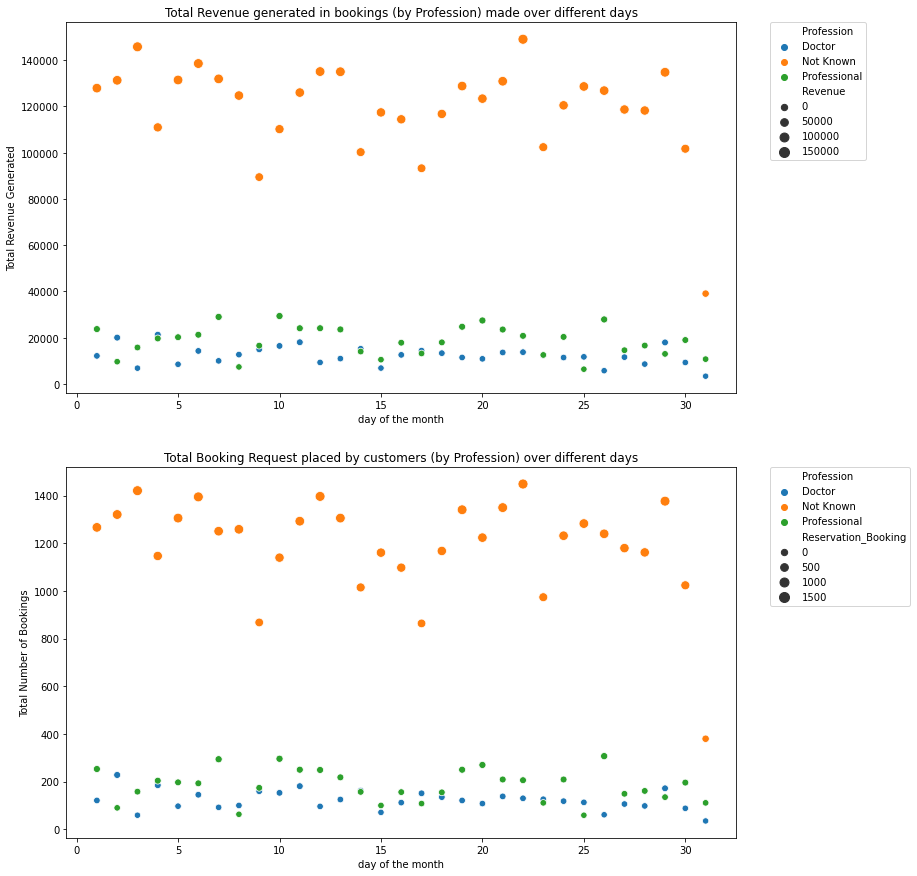

In [50]:
#Total Orders
Booking_Request_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","Profession",],sort=True)["Reservation_Booking"].sum()).reset_index()
# Revenue
Booking_Revenue_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","Profession",],sort=True)["Revenue"].sum()).reset_index()


fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.scatterplot(x= Booking_Request_ByDay["Booking_ST_Day"], y= Booking_Request_ByDay["Reservation_Booking"],hue=Booking_Request_ByDay["Profession"],size=Booking_Request_ByDay["Reservation_Booking"],sizes=(40, 100),data=Booking_Request_ByDay,ax=ax2)
ax2.set(xlabel='day of the month', ylabel='Total Number of Bookings',title="Total Booking Request placed by customers (by Profession) over different days",label='big')

# Put the legend out of the figure
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.scatterplot(x= Booking_Revenue_ByDay["Booking_ST_Day"], y= Booking_Revenue_ByDay["Revenue"],hue=Booking_Revenue_ByDay["Profession"],size=Booking_Revenue_ByDay["Revenue"],sizes=(40, 100), data=Booking_Revenue_ByDay,ax=ax1)
ax1.set(xlabel='day of the month', ylabel='Total Revenue Generated',title="Total Revenue generated in bookings (by Profession) made over different days",label='big')

# Put the legend out of the figure
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Visualizing Reservations Booking and Revenue by Sex - Male / Female and Not Known

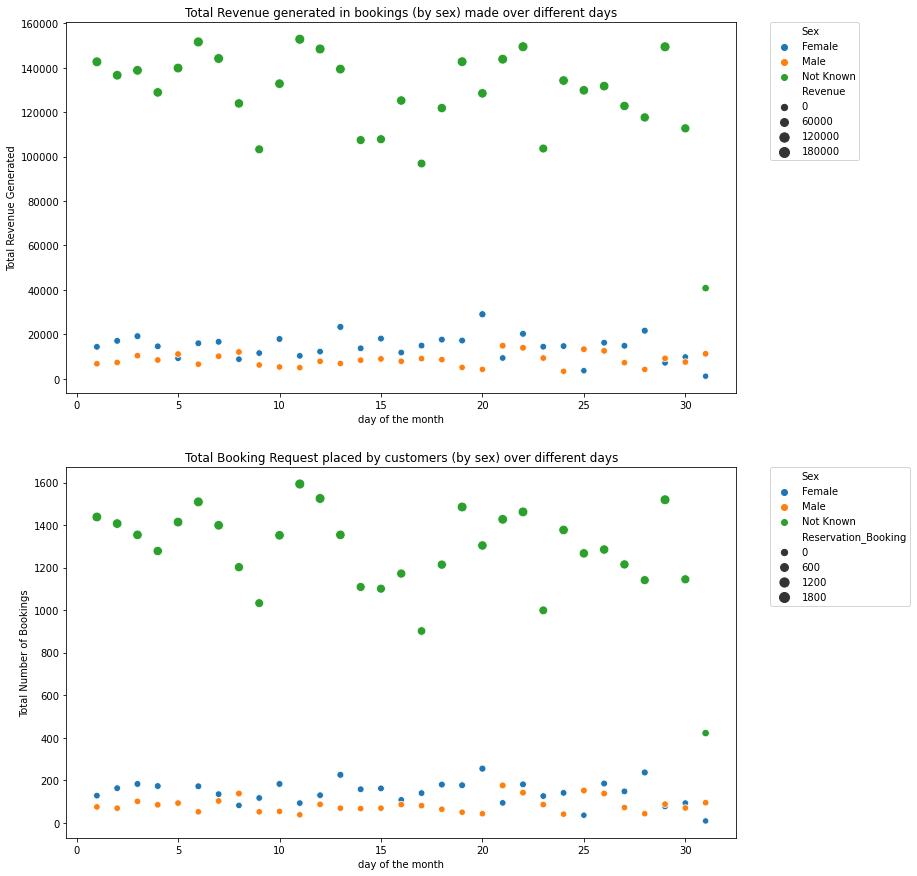

In [51]:
#Total Orders
Booking_Request_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","Sex"],sort=True)["Reservation_Booking"].sum()).reset_index()
# Revenue
Booking_Revenue_ByDay = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","Sex"],sort=True)["Revenue"].sum()).reset_index()


fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.scatterplot(x= Booking_Request_ByDay["Booking_ST_Day"], y= Booking_Request_ByDay["Reservation_Booking"],hue=Booking_Request_ByDay["Sex"],size=Booking_Request_ByDay["Reservation_Booking"],sizes=(40, 100),data=Booking_Request_ByDay,ax=ax2)
ax2.set(xlabel='day of the month', ylabel='Total Number of Bookings',title="Total Booking Request placed by customers (by sex) over different days",label='big')

# Put the legend out of the figure
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.scatterplot(x= Booking_Revenue_ByDay["Booking_ST_Day"], y= Booking_Revenue_ByDay["Revenue"],hue=Booking_Revenue_ByDay["Sex"],size=Booking_Revenue_ByDay["Revenue"],sizes=(40, 100), data=Booking_Revenue_ByDay,ax=ax1)
ax1.set(xlabel='day of the month', ylabel='Total Revenue Generated',title="Total Revenue generated in bookings (by sex) made over different days",label='big')

# Put the legend out of the figure
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [52]:
Booking_Revenue_ByProfession = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","room type","request type","Profession"],sort=True)["Revenue"].sum()).reset_index()
Booking_Revenue_BySex = pd.DataFrame(Booking_Request_R.groupby(["Booking_ST_Day","room type","request type","Sex"],sort=True)["Revenue"].sum()).reset_index()

In [53]:
Booking_Revenue_ByProfession.head(2)

,Booking_ST_Day,room type,request type,Profession,Revenue
0,1,conference_room_large,conference,Doctor,300
1,1,conference_room_large,conference,Not Known,2400


In [54]:
Booking_Revenue_BySex.head(2)

,Booking_ST_Day,room type,request type,Sex,Revenue
0,1,conference_room_large,conference,Not Known,4050
1,1,conference_room_large,party,Female,4200


#### Best Selling Room : Normal Room

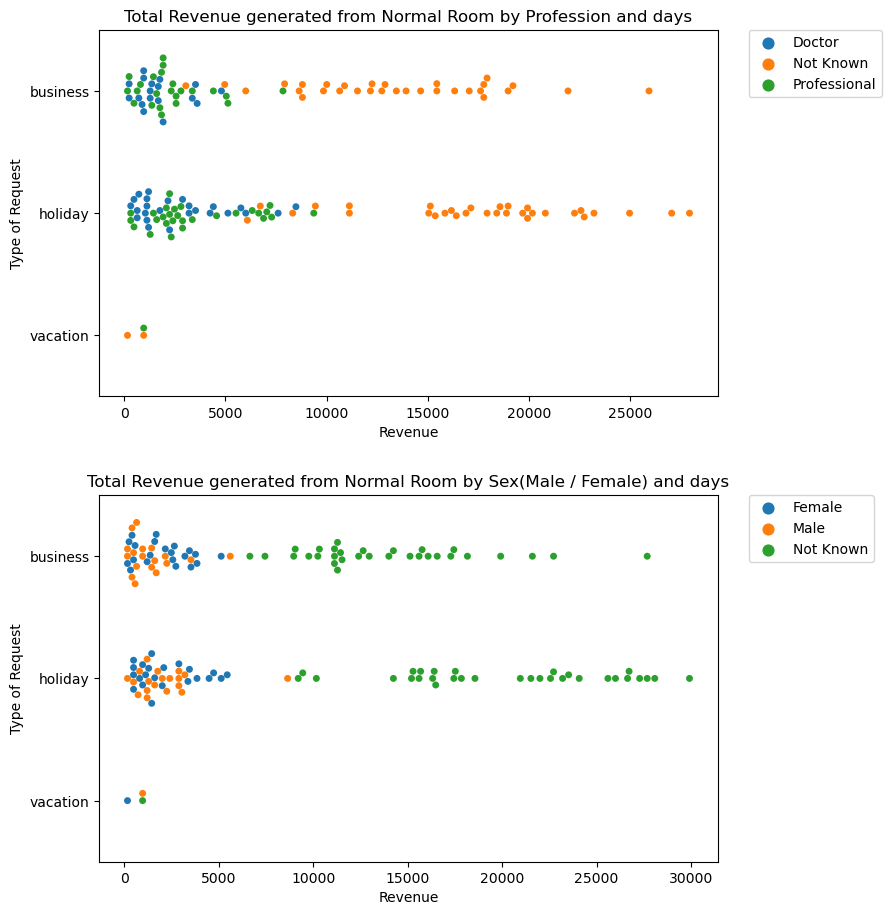

In [55]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Room_ByProfession = Booking_Revenue_ByProfession[Booking_Revenue_ByProfession['room type']=='normal_room']
Room_BySex = Booking_Revenue_BySex[Booking_Revenue_BySex['room type']=='normal_room']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Revenue", y= "request type", hue='Profession', data=Room_ByProfession, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Normal Room by Profession and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Revenue", y= "request type", hue='Sex', data=Room_BySex, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Normal Room by Sex(Male / Female) and days",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Second Best Selling Room : Conference Room Small

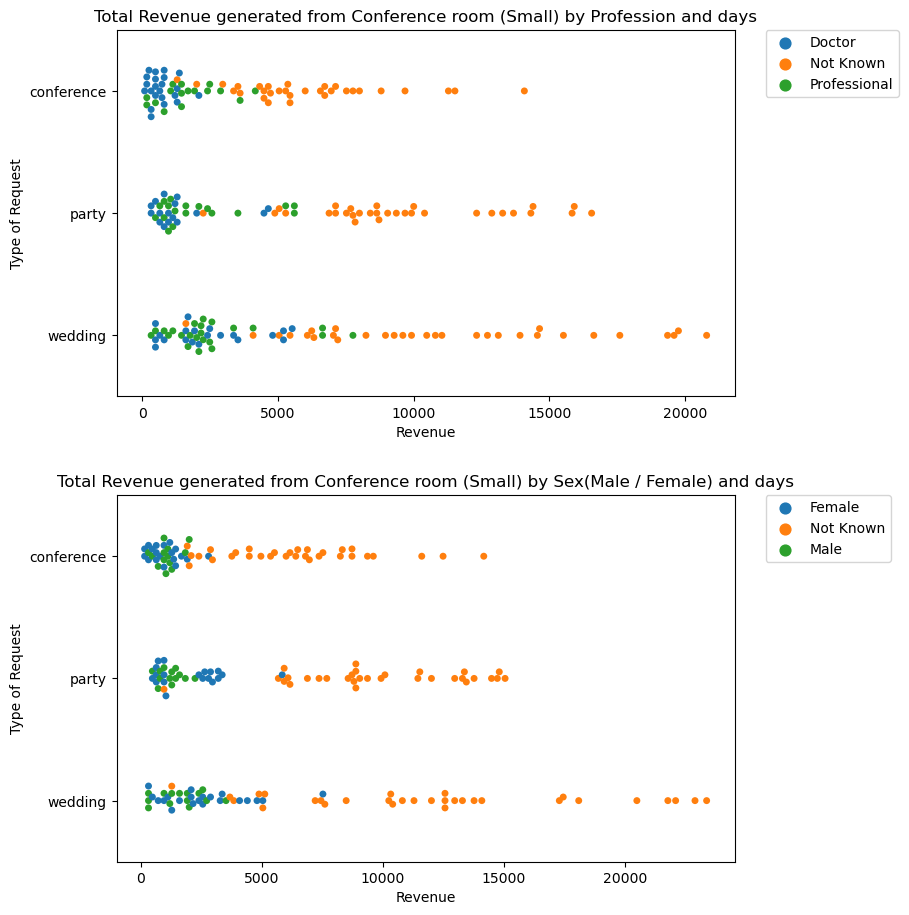

In [56]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Room_ByProfession = Booking_Revenue_ByProfession[Booking_Revenue_ByProfession['room type']=='conference_room_small']
Room_BySex = Booking_Revenue_BySex[Booking_Revenue_BySex['room type']=='conference_room_small']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Revenue", y= "request type", hue='Profession', data=Room_ByProfession, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Conference room (Small) by Profession and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Revenue", y= "request type", hue='Sex', data=Room_BySex, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Conference room (Small) by Sex(Male / Female) and days",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Other Room : Conference Room Large

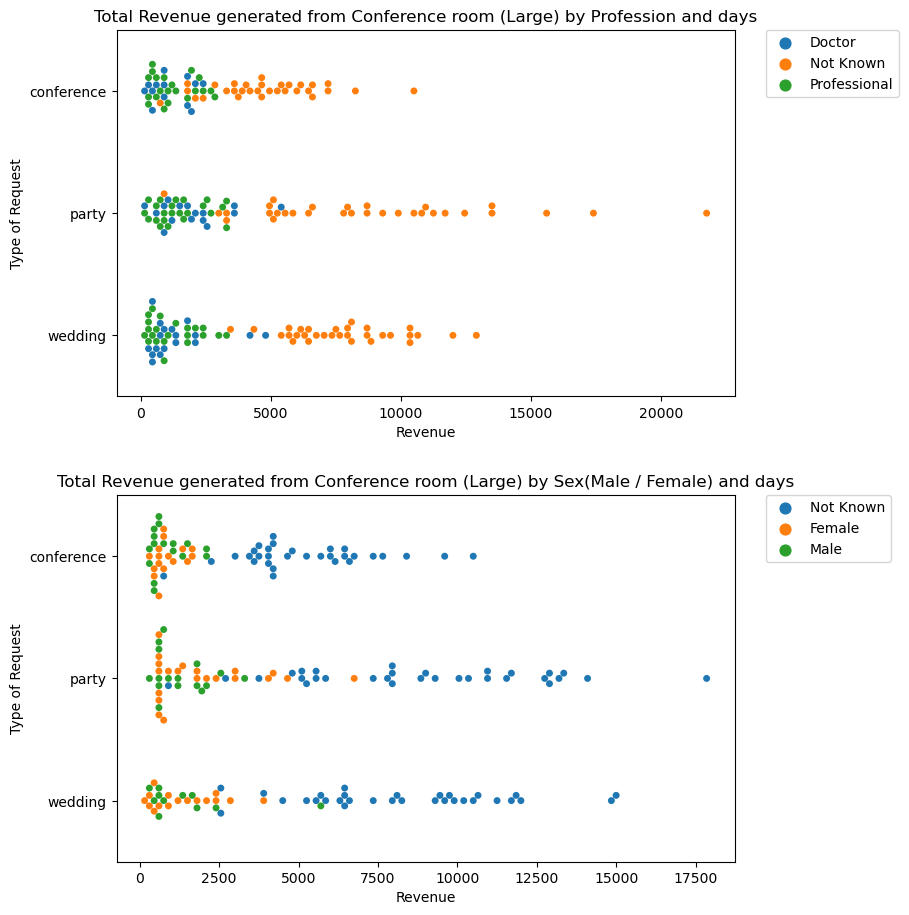

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Room_ByProfession = Booking_Revenue_ByProfession[Booking_Revenue_ByProfession['room type']=='conference_room_large']
Room_BySex = Booking_Revenue_BySex[Booking_Revenue_BySex['room type']=='conference_room_large']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Revenue", y= "request type", hue='Profession', data=Room_ByProfession, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Conference room (Large) by Profession and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Revenue", y= "request type", hue='Sex', data=Room_BySex, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Conference room (Large) by Sex(Male / Female) and days",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Other Room : Delux Room

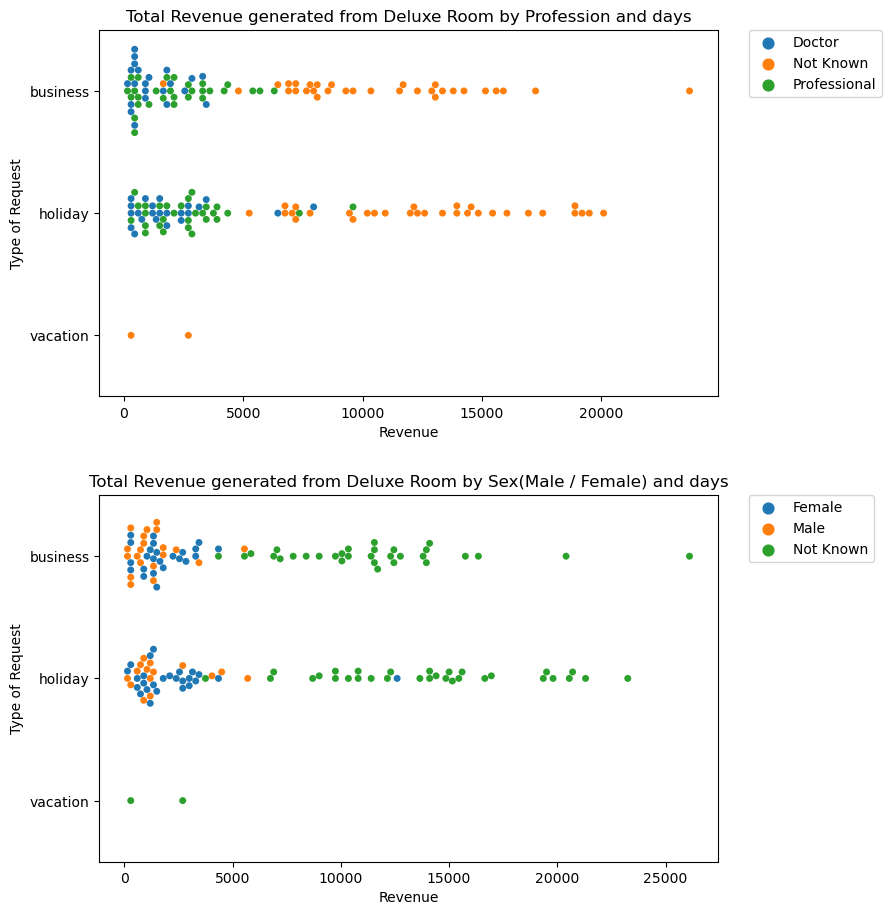

In [58]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Room_ByProfession = Booking_Revenue_ByProfession[Booking_Revenue_ByProfession['room type']=='deluxe_room']
Room_BySex = Booking_Revenue_BySex[Booking_Revenue_BySex['room type']=='deluxe_room']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Revenue", y= "request type", hue='Profession', data=Room_ByProfession, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Deluxe Room by Profession and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Revenue", y= "request type", hue='Sex', data=Room_BySex, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Deluxe Room by Sex(Male / Female) and days",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Other Room : Double Room

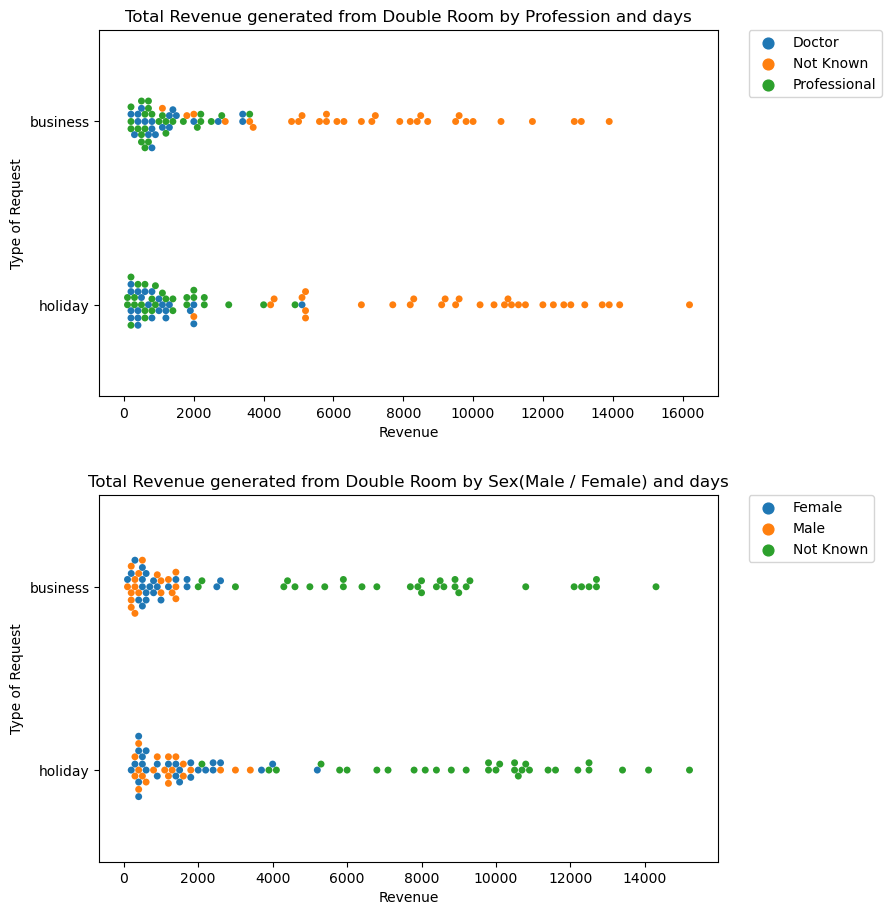

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Room_ByProfession = Booking_Revenue_ByProfession[Booking_Revenue_ByProfession['room type']=='double_room']
Room_BySex = Booking_Revenue_BySex[Booking_Revenue_BySex['room type']=='double_room']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Revenue", y= "request type", hue='Profession', data=Room_ByProfession, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Double Room by Profession and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Revenue", y= "request type", hue='Sex', data=Room_BySex, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Type of Request',title="Total Revenue generated from Double Room by Sex(Male / Female) and days",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Now Join the tables : Food Orders with Menu and Perform visualizations

In [60]:
Food_orders = pd.read_csv("../input/hotel-data/food-orders.csv",delimiter="|")
Food_orders.head(2)

,dest room,bill room,date,time,#orders,menu id
0,L0,L0,2016-02-09,10:15:00,3,6
1,restaurant,L0,2016-02-07,11:35:00,5,8


In [61]:
Food_orders = Food_orders.merge(Menu, on='menu id', how='left')
Food_orders.head(2)

,dest room,bill room,date,time,#orders,menu id,name,price,category
0,L0,L0,2016-02-09,10:15:00,3,6,deluxe-breakfast,12.0,breakfast
1,restaurant,L0,2016-02-07,11:35:00,5,8,deluxe-lunch,10.0,lunch


In [62]:
food_ac = np.vstack(Food_orders['date'].astype(str).apply(lambda x:list(map(int,x.split('-')))).values)
Food_orders['Food_Ordered_Year'] = food_ac[:,0]
Food_orders['Food_Ordered_Month']= food_ac[:,1]
Food_orders['Food_Ordered_Day'] = food_ac[:,2]

In [63]:
food_ac_2 = np.vstack(Food_orders['time'].astype(str).apply(lambda x:list(map(int,x.split(':')))).values)
Food_orders['Food_Ordered_hour'] = food_ac_2[:,0]
Food_orders['Food_Ordered_Minute']= food_ac_2[:,1]

In [64]:
Food_orders = Food_orders.drop(['date','time','Food_Ordered_Year','menu id','Food_Ordered_Minute'], axis=1)

In [65]:
Food_orders['Food_Revenue'] = Food_orders['#orders'] * Food_orders['price'] 

destination_room = np.array(Food_orders['dest room'])
Food_orders['Food_Location'] = np.where(destination_room=="restaurant","Restaurant","Hotel Room")
Food_orders = Food_orders.drop(['dest room'], axis=1)
Food_orders.head(5)

,bill room,#orders,name,price,category,Food_Ordered_Month,Food_Ordered_Day,Food_Ordered_hour,Food_Revenue,Food_Location
0,L0,3,deluxe-breakfast,12.0,breakfast,2,9,10,36.0,Hotel Room
1,L0,5,deluxe-lunch,10.0,lunch,2,7,11,50.0,Restaurant
2,L0,5,spareribs,17.0,dinner,3,17,6,85.0,Hotel Room
3,L0,4,simple-lunch,5.0,lunch,3,15,17,20.0,Restaurant
4,L0,5,simple-lunch,5.0,lunch,3,16,14,25.0,Hotel Room


In [66]:
obs = Food_orders.isnull().sum().sort_values(ascending = False)
percent = round(Food_orders.isnull().sum().sort_values(ascending = False)/len(Food_orders)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
Food_Location,0,0.0
Food_Revenue,0,0.0
Food_Ordered_hour,0,0.0
Food_Ordered_Day,0,0.0
Food_Ordered_Month,0,0.0
category,0,0.0
price,0,0.0
name,0,0.0
#orders,0,0.0
bill room,0,0.0


### Visualize the Food Orders placed by the customers

In [67]:
Food_Orders_ByMonth = pd.DataFrame(Food_orders.groupby(["Food_Ordered_Month"],sort=True)["Food_Revenue"].sum()).reset_index()

In [68]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Indicator(
    value = Food_Orders_ByMonth["Food_Revenue"][1],
    delta = {'reference': Food_Orders_ByMonth["Food_Revenue"][0]},
    title = {'text': "Revenue ($) on Food Order : Month 2"},
    gauge = {
        'axis': {'visible': False}},
    domain = {'row': 0, 'column': 0}))

fig.add_trace(go.Indicator(
    value = Food_Orders_ByMonth["Food_Revenue"][2],
    delta = {'reference': Food_Orders_ByMonth["Food_Revenue"][1]},
    title = {'text': "Revenue ($) on Food Order : Month 3"},
    gauge = {
        'axis' : {'visible': False}},
    domain = {'row': 0, 'column': 1}))


fig.update_layout(
    width=950,
    height=300,
    font=dict(
        size=12,
    ),
    grid = {'rows': 1, 'columns': 2, 'pattern': "independent"},
    template = {'data' : {'indicator': [{
        'mode' : "number+delta+gauge",
        'delta' : {'reference': 90}}]
                         }})

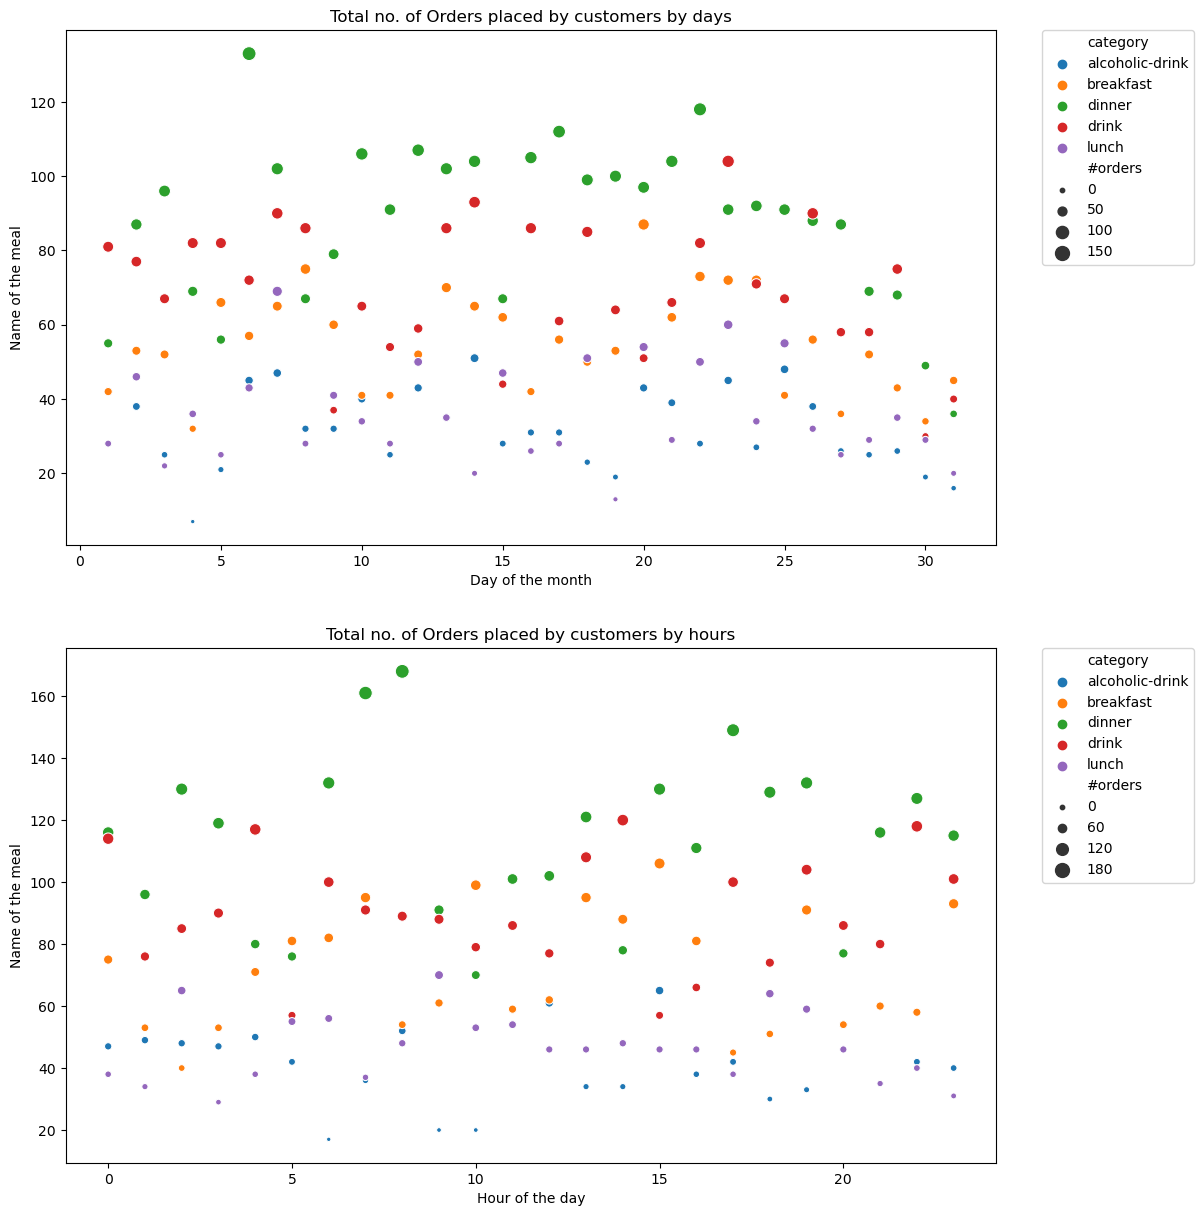

In [69]:
Food_Orders_ByDay = pd.DataFrame(Food_orders.groupby(["Food_Ordered_Day","category"],sort=True)["#orders"].sum()).reset_index()
Food_Orders_Byhour = pd.DataFrame(Food_orders.groupby(["Food_Ordered_hour","category",],sort=True)["#orders"].sum()).reset_index()

fig,(ax2,ax3)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.scatterplot(x= Food_Orders_ByDay["Food_Ordered_Day"], y= Food_Orders_ByDay["#orders"],hue=Food_Orders_ByDay["category"], size=Food_Orders_ByDay["#orders"],sizes=(10, 100), data=Food_Orders_ByDay,ax=ax2)
ax2.set(xlabel='Day of the month', ylabel='Name of the meal',title="Total no. of Orders placed by customers by days",label='big',)

p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.scatterplot(x= Food_Orders_Byhour["Food_Ordered_hour"], y= Food_Orders_Byhour["#orders"],hue=Food_Orders_Byhour["category"], size = Food_Orders_Byhour["#orders"],sizes=(10, 100), data=Food_Orders_Byhour,ax=ax3)
ax3.set(xlabel='Hour of the day', ylabel='Name of the meal',title="Total no. of Orders placed by customers by hours",label='big')

p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Visualize the revenue generated from the food items

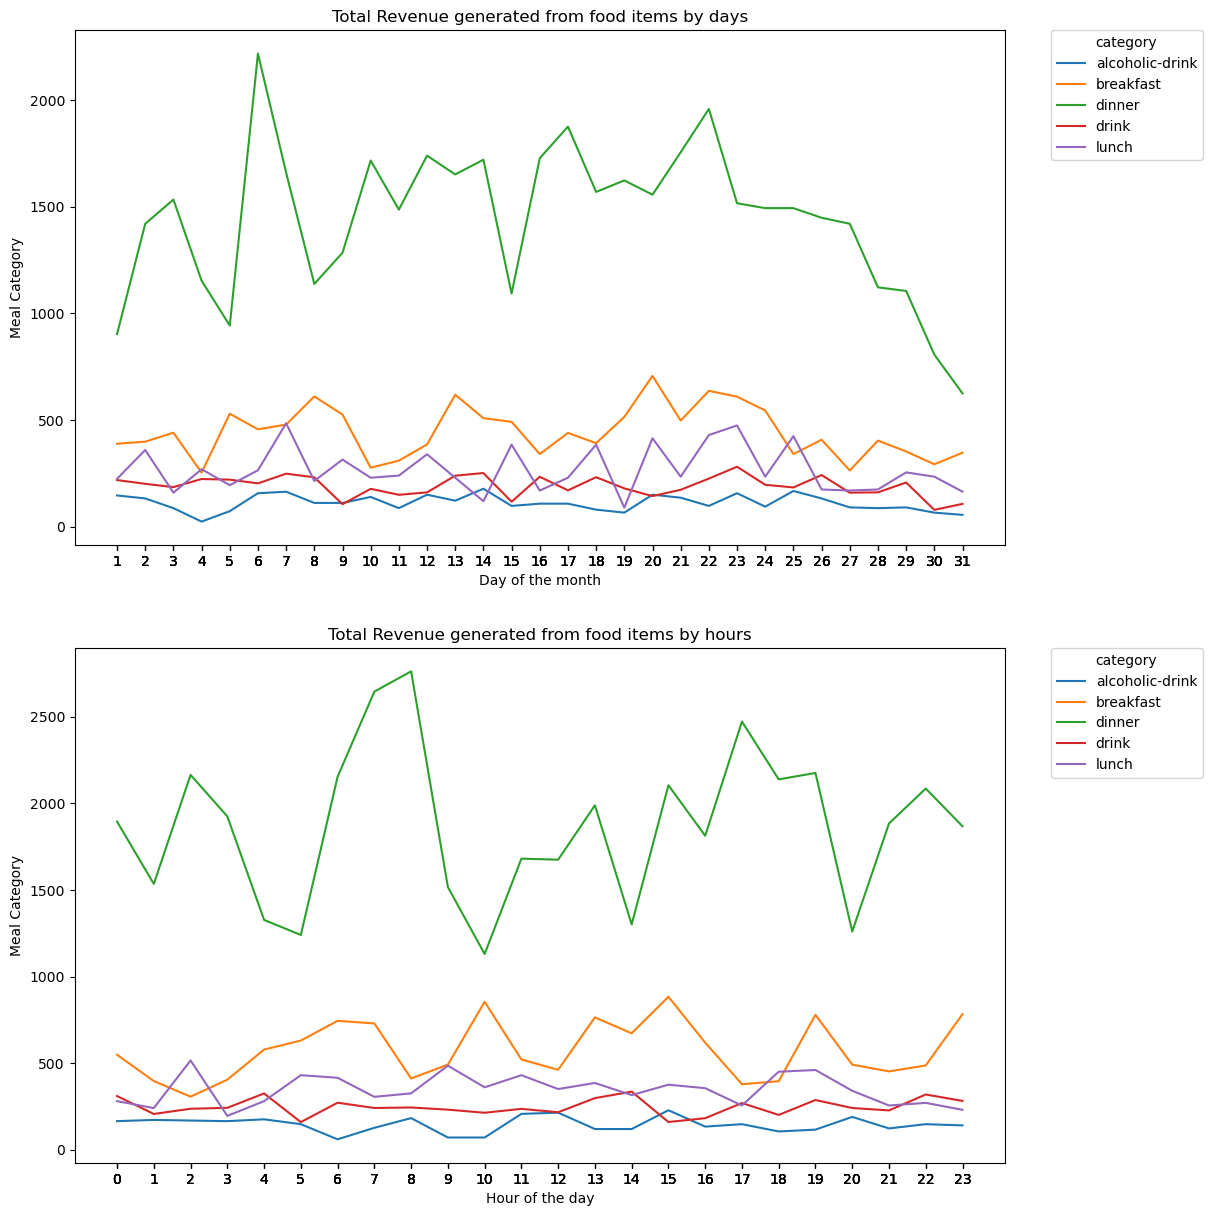

In [70]:
Food_Orders_ByDay = pd.DataFrame(Food_orders.groupby(["Food_Ordered_Day","category"],sort=True)["Food_Revenue"].sum()).reset_index()
Food_Orders_Byhour = pd.DataFrame(Food_orders.groupby(["Food_Ordered_hour","category",],sort=True)["Food_Revenue"].sum()).reset_index()

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(12, 15)

p1 = sns.lineplot(x= Food_Orders_ByDay["Food_Ordered_Day"], y= Food_Orders_ByDay["Food_Revenue"],hue=Food_Orders_ByDay["category"], data=Food_Orders_ByDay,ax=ax2)
ax2.set(xlabel='Day of the month', ylabel='Meal Category',title="Total Revenue generated from food items by days",label='big',xticks=Food_Orders_ByDay["Food_Ordered_Day"])

p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.lineplot(x= Food_Orders_Byhour["Food_Ordered_hour"], y= Food_Orders_Byhour["Food_Revenue"],hue=Food_Orders_Byhour["category"], data=Food_Orders_Byhour,ax=ax3)
ax3.set(xlabel='Hour of the day', ylabel='Meal Category',title="Total Revenue generated from food items by hours",label='big',xticks=Food_Orders_Byhour["Food_Ordered_hour"])

p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Lets Identify what's driving the best food and worst food**

In [71]:
Food_Category_ByDay = pd.DataFrame(Food_orders.groupby(["Food_Ordered_Day","category","name","Food_Location"],sort=True)["Food_Revenue"].sum()).reset_index()
Food_Category_Byhour = pd.DataFrame(Food_orders.groupby(["Food_Ordered_hour","category","name","Food_Location"],sort=True)["Food_Revenue"].sum()).reset_index()

In [72]:
Food_Category_ByDay.head(2)

,Food_Ordered_Day,category,name,Food_Location,Food_Revenue
0,1,alcoholic-drink,beer,Hotel Room,42.0
1,1,alcoholic-drink,beer,Restaurant,14.0


**Insights :** Best Selling Dinner! - Steak and Stuff and Surf n turf

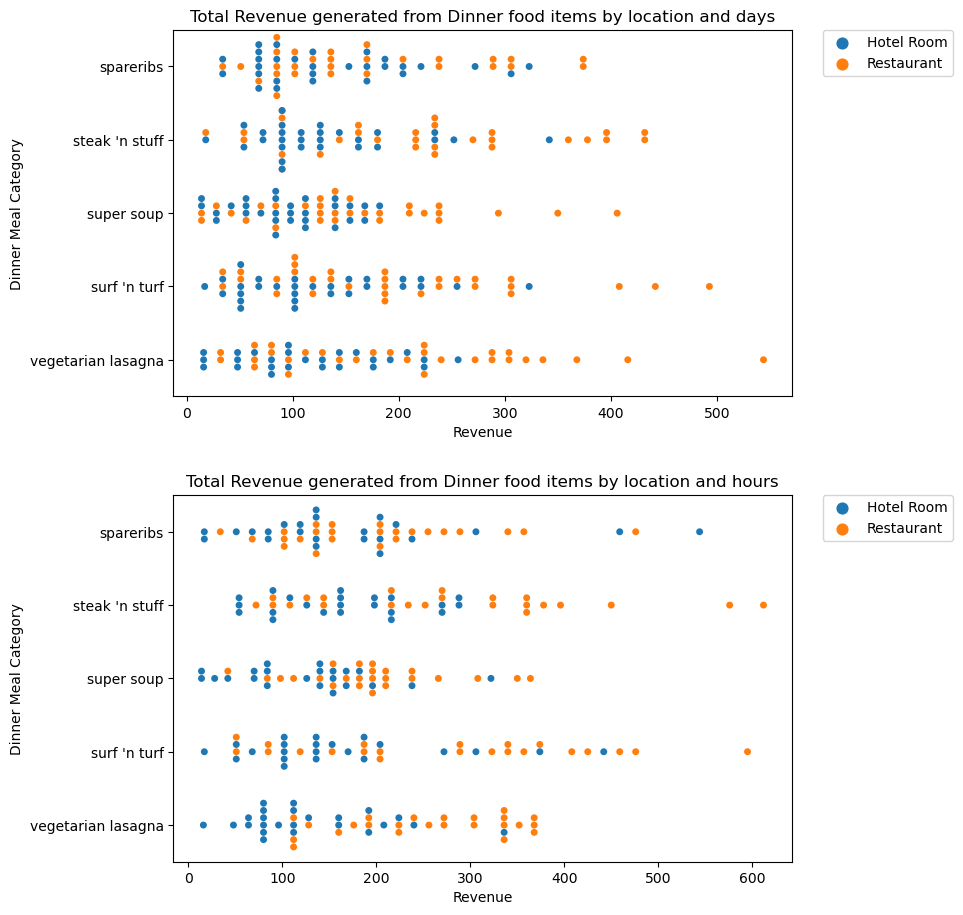

In [73]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

Dinner_ByDay = Food_Category_ByDay[Food_Category_ByDay['category']=='dinner']
Dinner_Byhour = Food_Category_Byhour[Food_Category_Byhour['category']=='dinner']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Dinner_ByDay, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Dinner Meal Category',title="Total Revenue generated from Dinner food items by location and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Dinner_Byhour, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Dinner Meal Category',title="Total Revenue generated from Dinner food items by location and hours",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Insights : Best Selling Breakfast! : Delux Breakfast

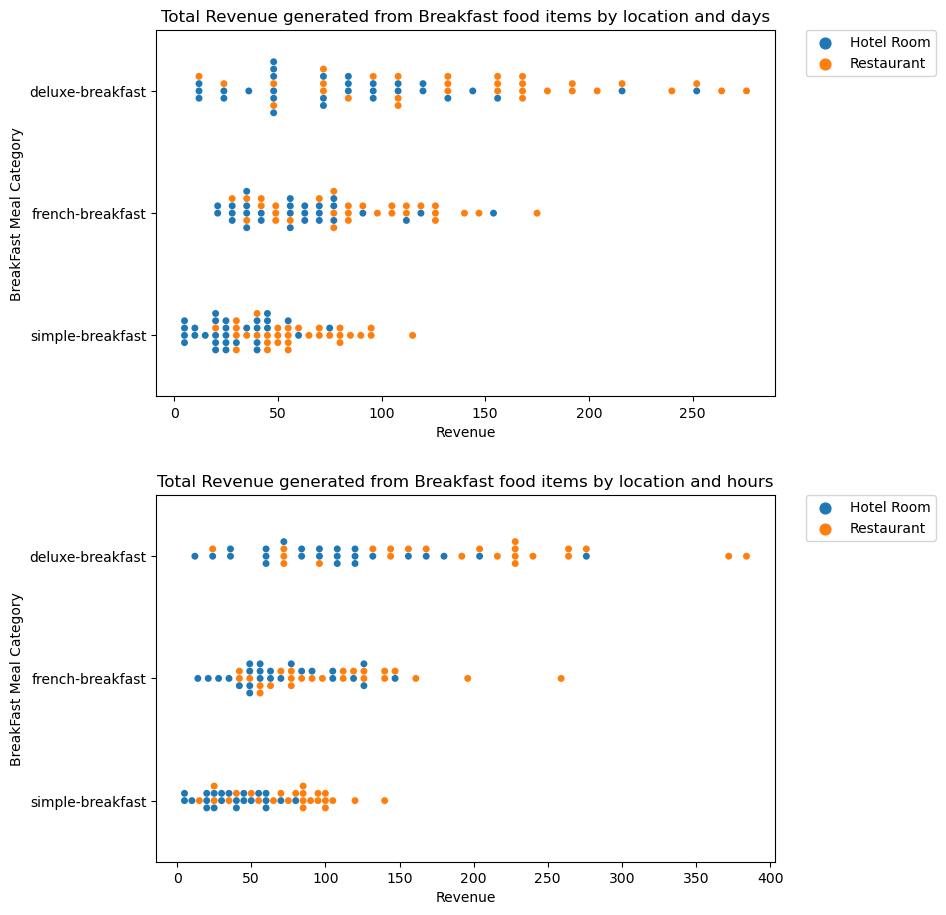

In [74]:
Breakfast_ByDay = Food_Category_ByDay[Food_Category_ByDay['category']=='breakfast']
Breakfast_Byhour = Food_Category_Byhour[Food_Category_Byhour['category']=='breakfast']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Breakfast_ByDay, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='BreakFast Meal Category',title="Total Revenue generated from Breakfast food items by location and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


p2 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Breakfast_Byhour, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='BreakFast Meal Category',title="Total Revenue generated from Breakfast food items by location and hours",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Insights : Best Selling Lunch - Delux Lunch

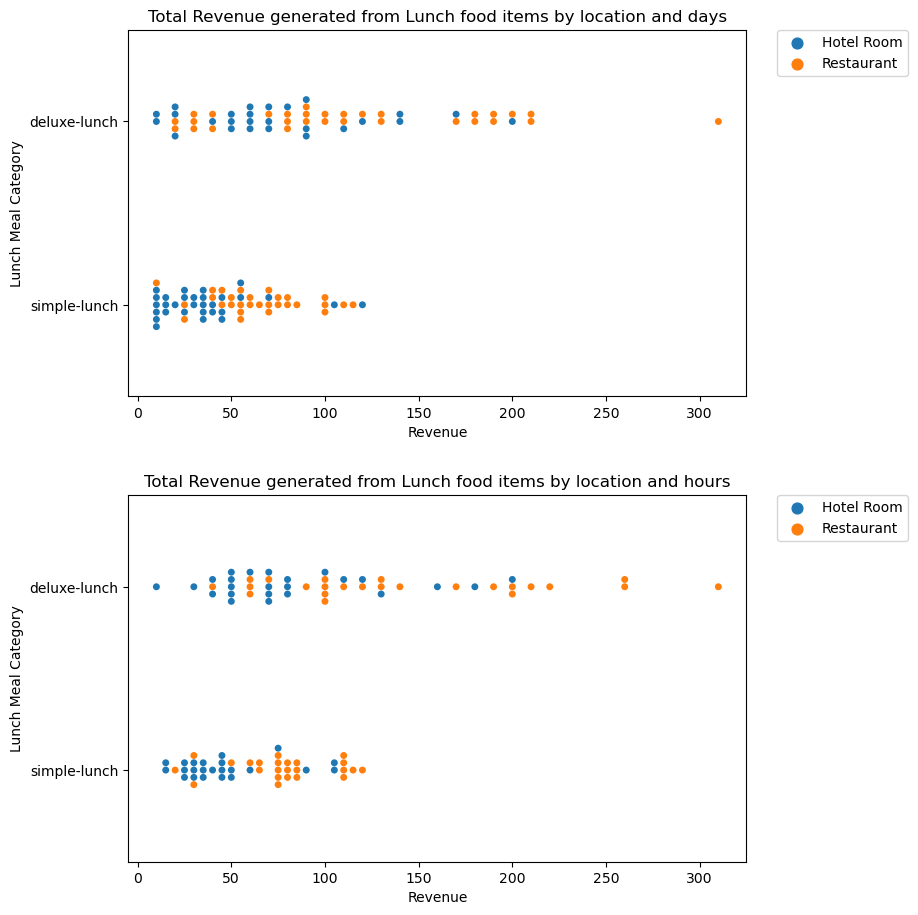

In [75]:
Lunch_ByDay = Food_Category_ByDay[Food_Category_ByDay['category']=='lunch']
Lunch_Byhour = Food_Category_Byhour[Food_Category_Byhour['category']=='lunch']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Lunch_ByDay, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Lunch Meal Category',title="Total Revenue generated from Lunch food items by location and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Lunch_Byhour, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Lunch Meal Category',title="Total Revenue generated from Lunch food items by location and hours",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Insights : Best Selling drinks- All drinks are equally famous!

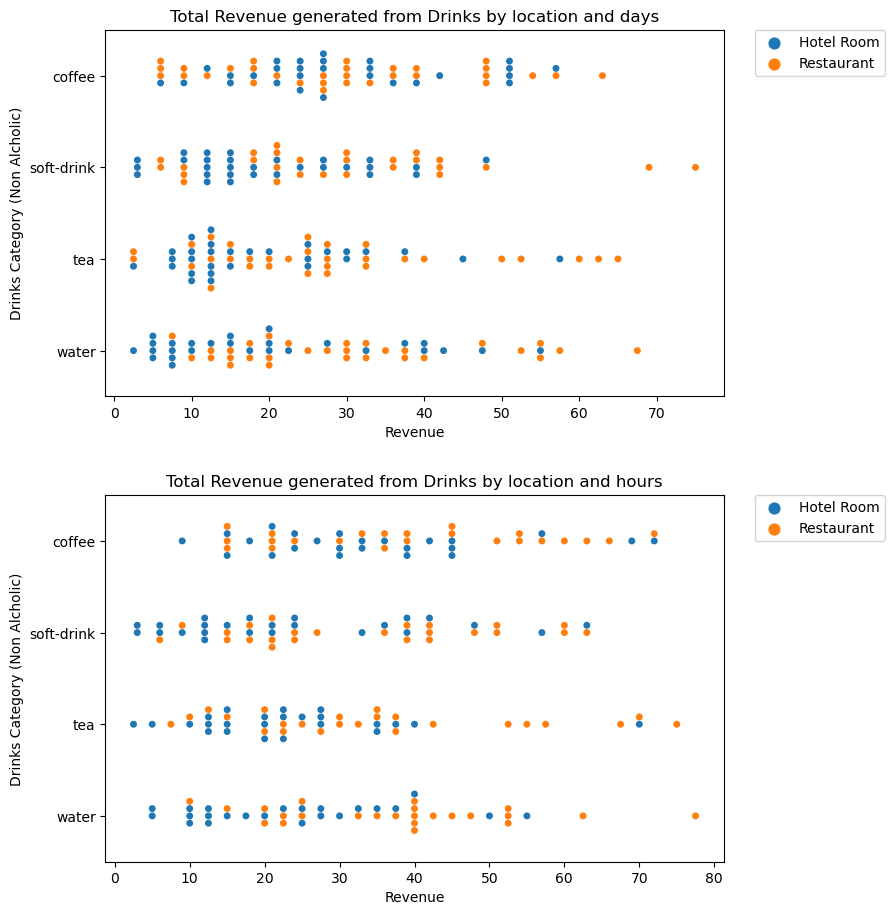

In [76]:
Drinks_ByDay = Food_Category_ByDay[Food_Category_ByDay['category']=='drink']
Drinks_Byhour = Food_Category_Byhour[Food_Category_Byhour['category']=='drink']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Drinks_ByDay, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Drinks Category (Non Alcholic)',title="Total Revenue generated from Drinks by location and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Drinks_Byhour, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Drinks Category (Non Alcholic)',title="Total Revenue generated from Drinks by location and hours",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Insights : Most customers order Alchohol inside the hotel room

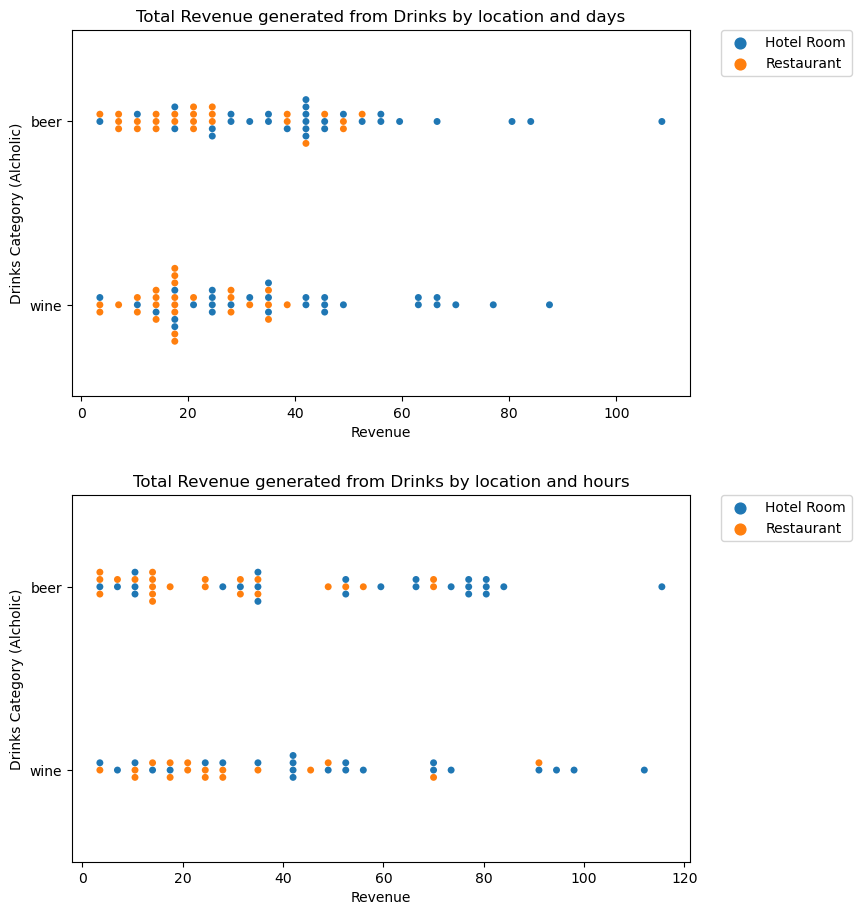

In [77]:
Drinks_ByDay = Food_Category_ByDay[Food_Category_ByDay['category']=='alcoholic-drink']
Drinks_Byhour = Food_Category_Byhour[Food_Category_Byhour['category']=='alcoholic-drink']

fig,(ax2, ax3)= plt.subplots(nrows=2)
fig.set_size_inches(8, 10)
fig.tight_layout(pad=5.0)

p1 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Drinks_ByDay, ax=ax2)
ax2.set(xlabel='Revenue', ylabel='Drinks Category (Alcholic)',title="Total Revenue generated from Drinks by location and days",label='big')
p1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

p2 = sns.swarmplot(x="Food_Revenue", y= "name", hue='Food_Location', data=Drinks_Byhour, ax=ax3)
ax3.set(xlabel='Revenue', ylabel='Drinks Category (Alcholic)',title="Total Revenue generated from Drinks by location and hours",label='big')
p2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)